In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [3]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 7106 images.
val_list has 375 images.


# 学習データの作成

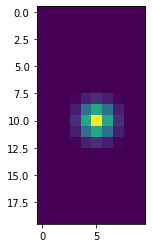

In [4]:
def get_heatmap(h, w, h_center, w_center, sigma=2):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [5]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisibleSurface(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    surface_coord3D = np.zeros([3,4])
    visible_flag = np.zeros(4)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        surface_coord3D[:,i] = c_plane
        if np.dot(c_to_O, normal)>0:
            visible_flag[i] = 1
    return visible_flag==1, surface_coord3D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return visible_mask!=0

def compute3Dbb(obj, P):
    # 直方体の各頂点のxyz座標を計算
    face_idx = np.array([[0,1,5,4], # front face
                         [1,2,6,5], # right face
                         [2,3,7,6], # back face
                         [3,0,4,7]]) # left face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz
    
    # 直方体の各頂点が見えているかどうかを判定
    visible_corner_flag = selectVisiblePoint(corner3D) # 見える頂点を判定
    corner_coord2D = projectToImage(corner3D, P) # 画像座標に変換
    
    # 直方体の面の座標、面が見えているかどうかを判定
    visible_surface_flag, surface_coord3D = selectVisibleSurface(corner3D)
    surface_coord2D = projectToImage(surface_coord3D, P)
    
    if xyz[2]<0.1:
        return []
    else:
        return visible_corner_flag, corner_coord2D, visible_surface_flag, surface_coord2D

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

In [6]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img, training=False):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    if training:
        off_x = randint(0, IMG_WIDTH-img_shape[1])
        off_y = randint(0, IMG_HEIGHT-img_shape[0])
    else:
        off_x = np.round((IMG_WIDTH-img_shape[1])/2).astype('int')
        off_y = np.round((IMG_HEIGHT-img_shape[0])/2).astype('int')
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    ## mask data
    # idx 0 : vehicle
    # idx 1 : front and rear side
    # idx 2 : right and left side
    # idx 3 : 3D corner
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 4], dtype='float32')
    ## size of the vehicle : width, height
    regr_size = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    ## offset for 3D detection
    # idx 0,10 : offset from vehicle center to front or rear surface | x, y
    # idx 1,11 : offset from vehicle center to right or left surface | x, y
    # idx 2~5,12~15 : offset from surface(front, rear) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    # idx 6~9,16~19 : offset from surface(right, or left) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    regr_3D = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 20], dtype='float32')
    
    # 車両が重なってmaskを0にしたところを判定。0で学習しないように。
    mask_overlap = np.zeros_like(mask)
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = x+offset[0]/ MODEL_SCALE
            y = y+offset[1]/ MODEL_SCALE
            
            width = width / RESIZE_SCALE
            height = height / RESIZE_SCALE

            ## corner, surfaceの座標を計算
            try: # 前後距離が小さいものは無視
                vsbl_cnr_flg, cnr, vsbl_sfc_flg, sfc = compute3Dbb(anno, P2)
            except:
                continue
            cnr[0] = (cnr[0]/RESIZE_SCALE + offset[0])/MODEL_SCALE
            cnr[1] = (cnr[1]/RESIZE_SCALE + offset[1])/MODEL_SCALE
            sfc[0] = (sfc[0]/RESIZE_SCALE + offset[0])/MODEL_SCALE
            sfc[1] = (sfc[1]/RESIZE_SCALE + offset[1])/MODEL_SCALE
            
            w = max(width,1)
            h = max(height,1)
            left = np.round(max(min(x-w/2,np.min(cnr[0])),0)).astype('int')
            top = np.round(max(min(y-h/2,np.min(cnr[1])),0)).astype('int')
            right = np.round(min(max(x+w/2,np.max(cnr[0])),IMG_WIDTH // MODEL_SCALE)).astype('int')
            bottom = np.round(min(max(y+h/2,np.max(cnr[1])),IMG_HEIGHT // MODEL_SCALE)).astype('int')
            hm = get_heatmap(right-left, bottom-top, x-left, y-top, 
                             sigma=max(min(right-left,bottom-top)/5,3))
            
            # 隠れている車両の正解データを消去(maskのみ)
            pts = cv2.convexHull(np.round(cnr).T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:bottom, left:right, 0] = hm
            regr_size[top:bottom, left:right, 0] = width
            regr_size[top:bottom, left:right, 1] = height
            
            # cregressionデータの初期化
            nums = np.arange(0,right-left,1)
            nums = np.tile(nums,10).reshape(10,right-left).T
            nums = np.tile(nums,(bottom-top,1)).reshape(bottom-top,right-left,10)
            regr_3D[top:bottom, left:right,:10] = nums
            nums = np.arange(0,bottom-top,1)
            nums = np.tile(nums,10).reshape(10,bottom-top).T
            nums = np.tile(nums,right-left).reshape(bottom-top,right-left,10)
            regr_3D[top:bottom, left:right,10:] = nums
            
            # 
            face_idx = np.array([[0,1,5,4], # front face
                                 [1,2,6,5], # right face
                                 [2,3,7,6], # back face
                                 [3,0,4,7]]) # left face
            ## front, rear
            for i in range(0,5,2):
                if i < 4 and vsbl_sfc_flg[i]==1:
                    # front, rear中心へのregressionを設定
                    regr_3D[top:bottom, left:right, 0] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right, 10] -= (sfc[1,i]-top) # yベクトル
                    
                    # front, rear中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[top:bottom, left:right,j+2] -= (sfc_cnr[0,j]-left)
                        regr_3D[top:bottom, left:right,j+2+10] -= (sfc_cnr[1,j]-top)
                    break
                elif i==4:
                    # frontもrearも見えていなかったら
                    regr_3D[top:bottom, left:right, 0] = 0 # xベクトル
                    regr_3D[top:bottom, left:right, 10] = 0 # yベクトル
            # right, left
            for i in range(1,6,2):
                if i < 5 and vsbl_sfc_flg[i]==1:
                    regr_3D[top:bottom, left:right, 1] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right, 11] -= (sfc[1,i]-top) # yベクトル
                    
                    # right, left中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[top:bottom, left:right,j+6] -= (sfc_cnr[0,j]-left)
                        regr_3D[top:bottom, left:right,j+6+10] -= (sfc_cnr[1,j]-top)
                    break
                elif i==5:
                    # rightもleftも見えていなかったら
                    regr_3D[top:bottom, left:right, 1] = 0 # xベクトル
                    regr_3D[top:bottom, left:right, 11] = 0 # yベクトル

            # cornerのmaskを作成
            cnr = cnr[:,vsbl_cnr_flg]
            cnr = np.round(cnr).astype('int')
            if w > 3:
                for i in range(cnr.shape[1]):
                    if 0 <= cnr[1,i] and cnr[1,i] < mask.shape[0] and\
                       0 <= cnr[0,i] and cnr[0,i] < mask.shape[1]:
                        # 画像外だったら何もしない
                        mask[cnr[1,i],cnr[0,i],3] = 1
            # surfaceのmaskを作成
            sfc = np.round(sfc).astype('int')
            if w > 3:
                for i in range(4):
                    if 0 <= sfc[1,i] and sfc[1,i] < mask.shape[0] and \
                       0 <= sfc[0,i] and sfc[0,i] < mask.shape[1] and \
                       vsbl_sfc_flg[i]==1:
                        # 画像外だったら何もしない
                        if i%2==0: # 前後面のmaskを設定
                            hm = get_heatmap(right-left, bottom-top, sfc[0,i]-left, sfc[1,i]-top, 
                                             sigma=max(min(right-left,bottom-top)/5,2))
                            mask[top:bottom, left:right, 1] = hm
                        else:
                            hm = get_heatmap(right-left, bottom-top, sfc[0,i]-left, sfc[1,i]-top, 
                                             sigma=max(min(right-left,bottom-top)/5,2))
                            mask[top:bottom, left:right, 2] = hm
            mask_overlap = np.maximum(mask_overlap, mask)
    
    mask_not_suppressed = (mask_overlap-mask)<0.1
    return mask, regr_size, regr_3D, mask_not_suppressed

In [7]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

In [8]:
img_name = train_list[8]
img_name_list = get_img_path([img_name])
img = plt.imread(img_name_list[0])
img, offset = preprocess_image(img)
mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, annotations_list, offset)

# 学習データ生成のためのclassを定義

In [9]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img, self.training)
        
        if self.training:
            mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, self.anno, offset)
            # Augmentation
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr_size, regr_3D, mask_not_suppressed =\
                    img[:,::-1], mask[:,::-1], regr_size[:,::-1], regr_3D[:,::-1], mask_not_suppressed[:,::-1]
                regr_3D[:,:,0:10] *= -1
                regr_3D = regr_3D[:,:,[0,1,3,2,5,4,7,6,9,8,10,11,13,12,15,14,17,16,19,18]] # corner regressionを左下から時計回りに修正
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr_size, regr_3D, mask_not_suppressed =\
                    img[::-1], mask[::-1], regr_size[::-1], regr_3D[::-1], mask_not_suppressed[::-1]
                regr_3D[:,:,10:] *= -1
                regr_3D = regr_3D[:,:,[0,1,5,4,3,2,9,8,7,6,10,11,15,14,13,12,19,18,17,16]] # corner regressionを左下から時計回りに修正
            
            # 配列の向き？を入れ替える
            mask = np.rollaxis(mask, 2, 0)
            regr_size = np.rollaxis(regr_size, 2, 0)
            regr_3D = np.rollaxis(regr_3D, 2, 0)
            mask_not_suppressed = np.rollaxis(mask_not_suppressed, 2, 0)
        img = np.rollaxis(img, 2, 0)
            
        if self.training:
            return [img.copy(), mask.copy(), regr_size.copy(), regr_3D.copy(), mask_not_suppressed.copy()]
        else:
            return img

In [10]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [11]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# DL Model

In [12]:
from efficientnet_pytorch import EfficientNet

In [13]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [14]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [15]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256)
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [16]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 50

## MyUNetの出力ベクトル長を設定
model = MyUNet(26).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=3,
                              verbose=True
                             )

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [17]:
lambda_size = 0.01
lambda_3D = 0.1

def criterion(prediction, mask, regr_size, regr_3D, mask_not_suppressed):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0:4])
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    # 車両のoverlapによりmaskが抑制されたところは、車両ありと推測しても罰則を与えない
    mask_loss = mask_loss * mask_not_suppressed
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression size loss
    pred_regr = prediction[:, 4:6]
    size_loss = (torch.abs(pred_regr - regr_size).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    size_loss = size_loss.mean(0)
    
    # Regression 3D loss
    pred_regr = prediction[:,[6,7,16,17]]
    regr = regr_3D[:,[0,1,10,11]]
    sfc_loss = (torch.abs(pred_regr - regr).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    sfc_loss = sfc_loss.mean(0)
    pred_regr = prediction[:,[8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25]]
    regr = regr_3D[:,[2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19]]
    cnr_loss = (torch.abs(pred_regr - regr).sum(1) * (mask[:,1]+mask[:,2])).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    cnr_loss = cnr_loss.mean(0)
    
    return mask_loss, lambda_size*size_loss, lambda_3D*(sfc_loss+cnr_loss)

In [18]:
FINE_TUNE_EPOCH = 30

def train_model(epoch, history=None):
    model.train()
    train_mask_loss = 0
    train_regr_size_loss = 0
    train_regr_3D_loss = 0
    
    for batch_idx, (img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)\
            in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_size_batch = regr_size_batch.to(device)
        regr_3D_batch = regr_3D_batch.to(device)
        mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        mask_loss, regr_size_loss, regr_3D_loss =\
            criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
        loss = mask_loss + regr_size_loss + regr_3D_loss
        loss.backward()
        optimizer.step()
            
        train_mask_loss += mask_loss.detach()
        train_regr_size_loss += regr_size_loss.detach()
        train_regr_3D_loss += regr_3D_loss.detach()
    
    train_mask_loss /= len(train_dataset)
    train_regr_size_loss /= len(train_dataset)
    train_regr_3D_loss /= len(train_dataset)
    train_loss = train_mask_loss + train_regr_size_loss + train_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'train_mask_loss'] = train_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_size_loss'] = train_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'train_regr_3D_loss'] = train_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'train_loss'] = train_loss.data.cpu().numpy()
        
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        train_loss))

def evaluate_model(epoch, history=None):
    model.eval()
    val_mask_loss = 0
    val_regr_size_loss = 0
    val_regr_3D_loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_size_batch = regr_size_batch.to(device)
            regr_3D_batch = regr_3D_batch.to(device)
            mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)

            output = model(img_batch)

            mask_loss, regr_size_loss, regr_3D_loss =\
                criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
                    
            val_mask_loss += mask_loss.detach()
            val_regr_size_loss += regr_size_loss.detach()
            val_regr_3D_loss += regr_3D_loss.detach()
    
    val_mask_loss /= len(val_dataset)
    val_regr_size_loss /= len(val_dataset)
    val_regr_3D_loss /= len(val_dataset)
    val_loss = val_mask_loss + val_regr_size_loss + val_regr_3D_loss
    
    if history is not None:
        history.loc[epoch, 'val_mask_loss'] = val_mask_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_size_loss'] = val_regr_size_loss.data.cpu().numpy()
        history.loc[epoch, 'val_regr_3D_loss'] = val_regr_3D_loss.data.cpu().numpy()
        history.loc[epoch, 'val_loss'] = val_loss.data.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(val_loss))
    
    scheduler.step(val_loss)

In [19]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    if epoch == 0:
        print("Base model parameters are FREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = False
    elif epoch == FINE_TUNE_EPOCH:
        print("Base model parameters are UNFREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = True
            
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')

Base model parameters are FREEZED.


100%|██████████| 445/445 [08:57<00:00,  1.21s/it]

Train Epoch: 0 	LR: 0.100000	Loss: 24.060053


Val loss: 65.9723


100%|██████████| 445/445 [09:26<00:00,  1.27s/it]

Train Epoch: 1 	LR: 0.100000	Loss: 20.561661


Val loss: 19.6897


100%|██████████| 445/445 [08:27<00:00,  1.14s/it]

Train Epoch: 2 	LR: 0.100000	Loss: 19.485291


Val loss: 17.0184


100%|██████████| 445/445 [08:31<00:00,  1.15s/it]

Train Epoch: 3 	LR: 0.100000	Loss: 18.330460


Val loss: 16.1917


100%|██████████| 445/445 [08:21<00:00,  1.13s/it]

Train Epoch: 4 	LR: 0.100000	Loss: 17.656883


Val loss: 16.0063


100%|██████████| 445/445 [08:15<00:00,  1.11s/it]

Train Epoch: 5 	LR: 0.100000	Loss: 17.071428


Val loss: 15.1575


100%|██████████| 445/445 [08:20<00:00,  1.12s/it]

Train Epoch: 6 	LR: 0.100000	Loss: 16.658884


Val loss: 14.8273


100%|██████████| 445/445 [09:23<00:00,  1.27s/it]

Train Epoch: 7 	LR: 0.100000	Loss: 16.456928


Val loss: 14.7695


100%|██████████| 445/445 [09:24<00:00,  1.27s/it]

Train Epoch: 8 	LR: 0.100000	Loss: 16.250610


Val loss: 14.4322


100%|██████████| 445/445 [09:25<00:00,  1.27s/it]

Train Epoch: 9 	LR: 0.100000	Loss: 15.978658


Val loss: 14.1835


100%|██████████| 445/445 [09:13<00:00,  1.24s/it]

Train Epoch: 10 	LR: 0.100000	Loss: 15.825048


Val loss: 13.8834


100%|██████████| 445/445 [09:01<00:00,  1.22s/it]

Train Epoch: 11 	LR: 0.100000	Loss: 15.600685


Val loss: 14.0594


100%|██████████| 445/445 [08:59<00:00,  1.21s/it]

Train Epoch: 12 	LR: 0.100000	Loss: 15.562340


Val loss: 13.8845


100%|██████████| 445/445 [09:14<00:00,  1.25s/it]

Train Epoch: 13 	LR: 0.100000	Loss: 15.417933


Val loss: 13.7486


100%|██████████| 445/445 [09:28<00:00,  1.28s/it]

Train Epoch: 14 	LR: 0.100000	Loss: 15.295918


Val loss: 13.7107


100%|██████████| 445/445 [09:40<00:00,  1.31s/it]

Train Epoch: 15 	LR: 0.100000	Loss: 15.149178


Val loss: 13.5665


100%|██████████| 445/445 [09:38<00:00,  1.30s/it]

Train Epoch: 16 	LR: 0.100000	Loss: 15.164282


Val loss: 14.5664


100%|██████████| 445/445 [09:05<00:00,  1.23s/it]

Train Epoch: 17 	LR: 0.100000	Loss: 15.030179


Val loss: 13.5516


100%|██████████| 445/445 [08:54<00:00,  1.20s/it]

Train Epoch: 18 	LR: 0.100000	Loss: 14.934772


Val loss: 13.8877


100%|██████████| 445/445 [09:32<00:00,  1.29s/it]

Train Epoch: 19 	LR: 0.100000	Loss: 15.071314


Val loss: 13.3745


100%|██████████| 445/445 [08:57<00:00,  1.21s/it]

Train Epoch: 20 	LR: 0.100000	Loss: 14.841383


Val loss: 13.0850


100%|██████████| 445/445 [09:09<00:00,  1.23s/it]

Train Epoch: 21 	LR: 0.100000	Loss: 14.752068


Val loss: 13.5762


100%|██████████| 445/445 [09:42<00:00,  1.31s/it]

Train Epoch: 22 	LR: 0.100000	Loss: 14.672326


Val loss: 13.2393


100%|██████████| 445/445 [09:47<00:00,  1.32s/it]

Train Epoch: 23 	LR: 0.100000	Loss: 14.624507


Val loss: 13.3494


100%|██████████| 445/445 [09:48<00:00,  1.32s/it]

Train Epoch: 24 	LR: 0.100000	Loss: 14.602111


Val loss: 13.2405
Epoch    25: reducing learning rate of group 0 to 1.0000e-02.


100%|██████████| 445/445 [09:27<00:00,  1.28s/it]

Train Epoch: 25 	LR: 0.010000	Loss: 13.955460


Val loss: 12.5417


100%|██████████| 445/445 [09:34<00:00,  1.29s/it]

Train Epoch: 26 	LR: 0.010000	Loss: 13.718767


Val loss: 12.4580


100%|██████████| 445/445 [09:28<00:00,  1.28s/it]

Train Epoch: 27 	LR: 0.010000	Loss: 13.699314


Val loss: 12.4624


100%|██████████| 445/445 [09:18<00:00,  1.26s/it]

Train Epoch: 28 	LR: 0.010000	Loss: 13.645220


Val loss: 12.4383


100%|██████████| 445/445 [09:01<00:00,  1.22s/it]

Train Epoch: 29 	LR: 0.010000	Loss: 13.566395


Val loss: 12.3655


  0%|          | 0/445 [00:00<?, ?it/s]

Base model parameters are UNFREEZED.


100%|██████████| 445/445 [16:40<00:00,  2.25s/it]

Train Epoch: 30 	LR: 0.010000	Loss: 16.707047


Val loss: 26.6709


100%|██████████| 445/445 [16:08<00:00,  2.18s/it]

Train Epoch: 31 	LR: 0.010000	Loss: 15.441966


Val loss: 22.4910


100%|██████████| 445/445 [16:18<00:00,  2.20s/it]

Train Epoch: 32 	LR: 0.010000	Loss: 15.154192


Val loss: 33.0379


100%|██████████| 445/445 [15:58<00:00,  2.15s/it]

Train Epoch: 33 	LR: 0.010000	Loss: 15.025846


Val loss: 14.9152
Epoch    34: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████| 445/445 [16:09<00:00,  2.18s/it]

Train Epoch: 34 	LR: 0.001000	Loss: 14.347891


Val loss: 12.4649


100%|██████████| 445/445 [15:51<00:00,  2.14s/it]

Train Epoch: 35 	LR: 0.001000	Loss: 14.112183


Val loss: 12.4485


100%|██████████| 445/445 [15:56<00:00,  2.15s/it]

Train Epoch: 36 	LR: 0.001000	Loss: 13.942146


Val loss: 12.2873


100%|██████████| 445/445 [15:37<00:00,  2.11s/it]

Train Epoch: 37 	LR: 0.001000	Loss: 13.784222


Val loss: 12.2717


100%|██████████| 445/445 [15:38<00:00,  2.11s/it]

Train Epoch: 38 	LR: 0.001000	Loss: 13.698198


Val loss: 12.3430


100%|██████████| 445/445 [15:49<00:00,  2.13s/it]

Train Epoch: 39 	LR: 0.001000	Loss: 13.571763


Val loss: 12.1359


100%|██████████| 445/445 [15:40<00:00,  2.11s/it]

Train Epoch: 40 	LR: 0.001000	Loss: 13.523687


Val loss: 11.9195


100%|██████████| 445/445 [15:49<00:00,  2.13s/it]

Train Epoch: 41 	LR: 0.001000	Loss: 13.485077


Val loss: 12.0077


100%|██████████| 445/445 [16:02<00:00,  2.16s/it]

Train Epoch: 42 	LR: 0.001000	Loss: 13.396867


Val loss: 11.9244


100%|██████████| 445/445 [16:25<00:00,  2.22s/it]

Train Epoch: 43 	LR: 0.001000	Loss: 13.275951


Val loss: 11.9029


100%|██████████| 445/445 [16:45<00:00,  2.26s/it]

Train Epoch: 44 	LR: 0.001000	Loss: 13.281101


Val loss: 11.8038


100%|██████████| 445/445 [16:42<00:00,  2.25s/it]

Train Epoch: 45 	LR: 0.001000	Loss: 13.184837


Val loss: 11.7343


100%|██████████| 445/445 [16:34<00:00,  2.24s/it]

Train Epoch: 46 	LR: 0.001000	Loss: 13.082494


Val loss: 11.6477


100%|██████████| 445/445 [16:18<00:00,  2.20s/it]

Train Epoch: 47 	LR: 0.001000	Loss: 13.082660


Val loss: 11.7812


100%|██████████| 445/445 [16:32<00:00,  2.23s/it]

Train Epoch: 48 	LR: 0.001000	Loss: 13.006080


Val loss: 11.7562


100%|██████████| 445/445 [16:19<00:00,  2.20s/it]

Train Epoch: 49 	LR: 0.001000	Loss: 12.921727


Val loss: 11.6328


In [20]:
torch.save(model.state_dict(), '../models/model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), '../models/model_cpu.pth')

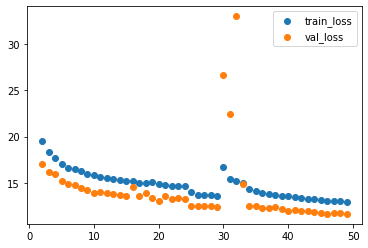

In [21]:
train_loss = history.dropna()['train_loss']
val_loss = history.dropna()['val_loss']
plt.scatter(train_loss.index[2:], train_loss[2:])
plt.scatter(val_loss.index[2:], val_loss[2:])
plt.legend(["train_loss", "val_loss"])

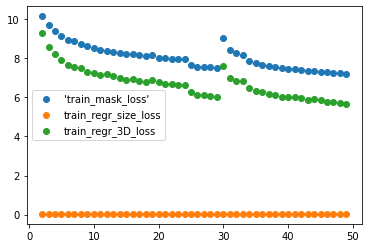

In [22]:
train_mask_loss = history.dropna()['train_mask_loss']
train_regr_size_loss = history.dropna()['train_regr_size_loss']
train_regr_3D_loss = history.dropna()['train_regr_3D_loss']
plt.scatter(train_loss.index[2:], train_mask_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_size_loss[2:])
plt.scatter(train_loss.index[2:], train_regr_3D_loss[2:])
plt.legend(["'train_mask_loss'", "train_regr_size_loss", "train_regr_3D_loss"])

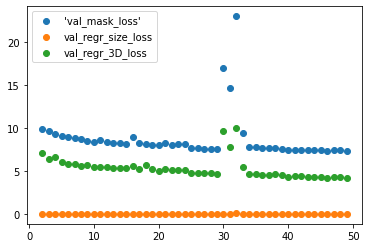

In [23]:
val_mask_loss = history.dropna()['val_mask_loss']
val_regr_size_loss = history.dropna()['val_regr_size_loss']
val_regr_3D_loss = history.dropna()['val_regr_3D_loss']
plt.scatter(val_loss.index[2:], val_mask_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_size_loss[2:])
plt.scatter(val_loss.index[2:], val_regr_3D_loss[2:])
plt.legend(["'val_mask_loss'", "val_regr_size_loss", "val_regr_3D_loss"])

In [24]:
torch.cuda.empty_cache()
gc.collect()

0

# Check result

In [25]:
m = MyUNet(26)
m.eval()
m_state_dict = torch.load("../models/model.pth")
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

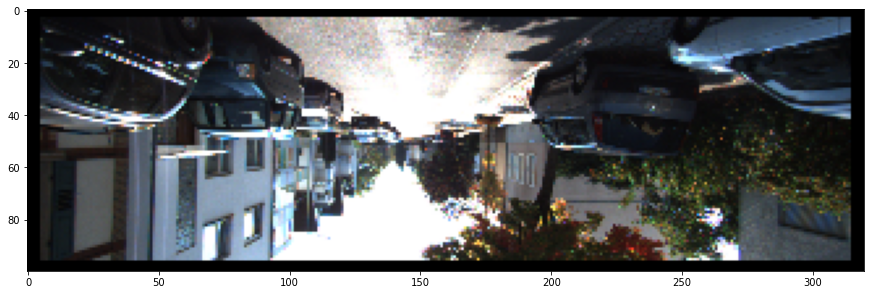

In [26]:
img, mask, regr, cnr, regr_cnr = val_dataset[0]
img2 = np.rollaxis(img, 0, 3)
plt.figure(figsize=(15,8))
plt.imshow(img2*255)

In [27]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

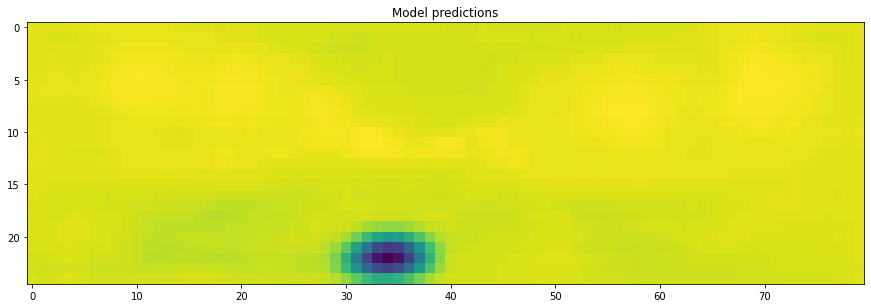

In [28]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

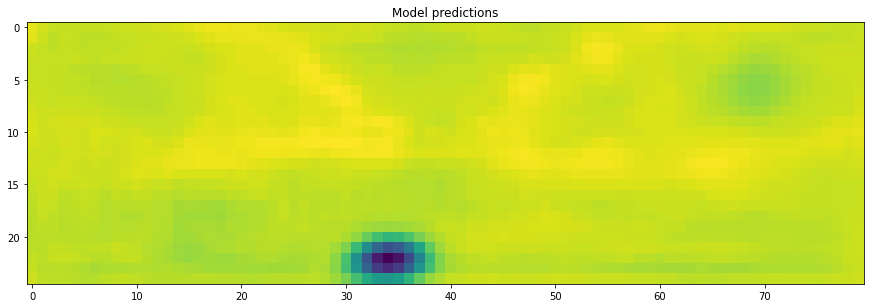

In [29]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,3].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

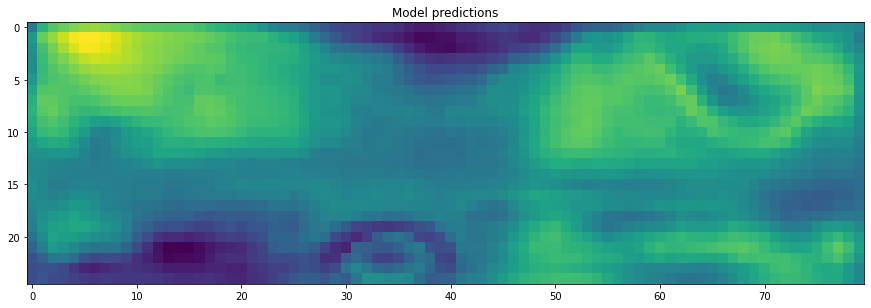

In [30]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,4].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()